## Datasets

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def parse_ripley_data(file):
    with open(file) as f:
        lines = f.readlines()[1:]
    n = len(lines)
    X, y = np.zeros((n, 2), dtype=float), np.zeros(n, dtype=int)
    for i, line in enumerate(lines):
        values = line.split()
        X[i, 0], X[i, 1] = float(values[0]), float(values[1])
        y[i] = int(values[2])
    return X, y

In [3]:
X_tr, y_tr = parse_ripley_data('data/synth.tr.txt')
X_te, y_te = parse_ripley_data('data/synth.te.txt')

In [4]:
X_tr.shape, X_te.shape

((250, 2), (1000, 2))

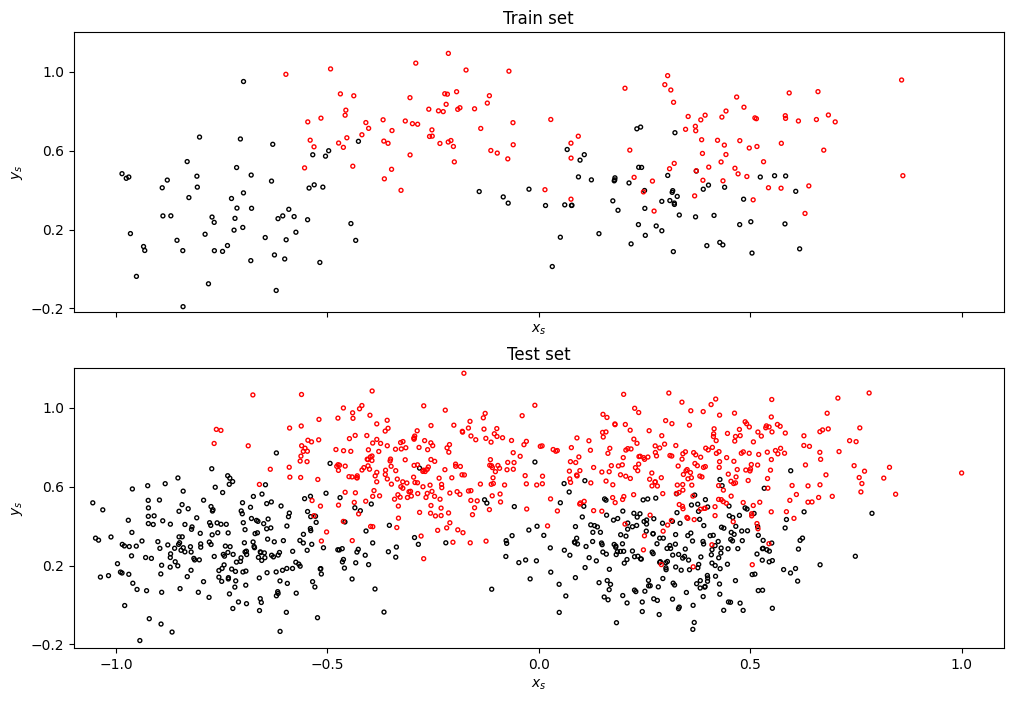

In [5]:
## figure 1

c = {1:"red", 0:"black"}

f, ax = plt.subplots(2, 1, figsize=(12, 8), sharey=True, sharex=True)

ax[0].set_title("Train set")
ax[0].scatter(X_tr[:, 0], X_tr[:, 1],facecolors='none', edgecolors=[c[y] for y in y_tr], s=8)
ax[0].set_xlabel(r"$x_s$")
ax[0].set_ylabel(r"$y_s$")
ax[0].set_xlim(-1.1, 1.1)
ax[0].set_xticks(np.arange(-1, 1.1, 0.5))
ax[0].set_ylim(-.22, 1.2)
ax[0].set_yticks([-.2, .2, .6, 1.])

ax[1].set_title("Test set")
ax[1].scatter(X_te[:, 0], X_te[:, 1],facecolors='none', edgecolors=[c[y] for y in y_te], s=8)
ax[1].set_xlabel(r"$x_s$")
ax[1].set_ylabel(r"$y_s$")
ax[1].set_xlim(-1.1, 1.1)
ax[1].set_xticks(np.arange(-1, 1.1, 0.5))
ax[1].set_ylim(-.22, 1.2)
ax[1].set_yticks([-.2, .2, .6, 1.])
plt.show()

# Vanilla KNN

In [7]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss

In [8]:
loo = LeaveOneOut()
N_NEIGHBORS = list(range(1, 126))
errors = np.zeros(len(N_NEIGHBORS))

for n_neighbors in N_NEIGHBORS:
    KNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    for train_index, validation_index in loo.split(X_tr):
        X_train, X_validation = X_tr[train_index], X_tr[validation_index]
        y_train, y_validation = y_tr[train_index], y_tr[validation_index]
        KNN.fit(X_train, y_train)
        
        errors[n_neighbors-1] += zero_one_loss(y_validation, KNN.predict(X_validation), normalize=False)

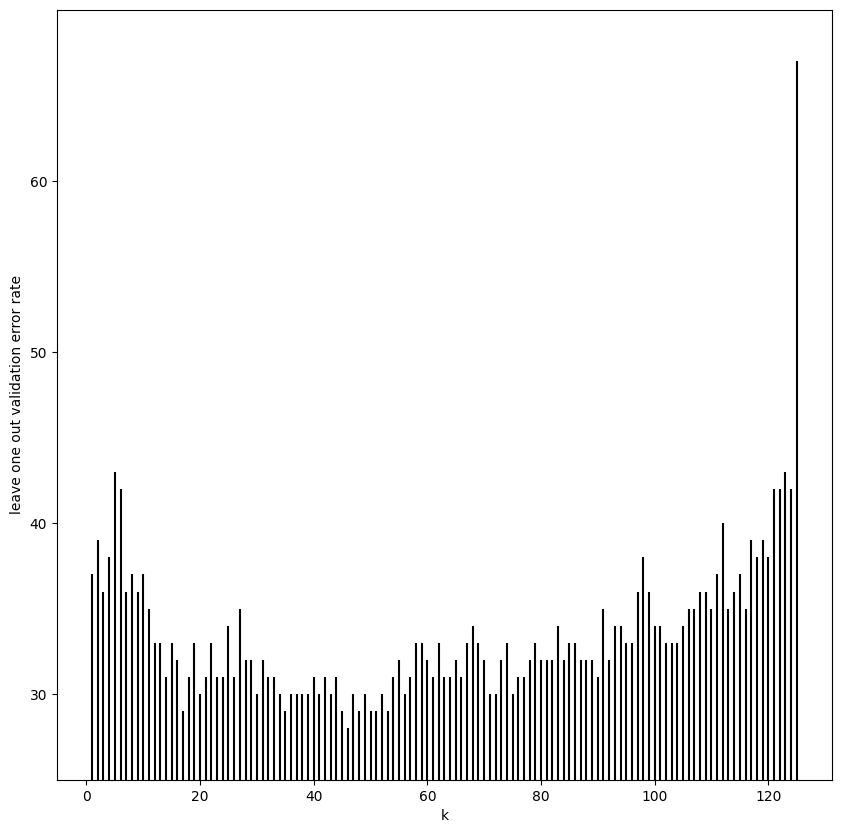

In [9]:
## figure 2

plt.figure(figsize=(10, 10))
plt.stem(N_NEIGHBORS, errors, linefmt="black", markerfmt=' ')
plt.xlabel("k")
plt.xticks(list(range(0, 121, 20)))
plt.ylabel("leave one out validation error rate")
plt.yticks(list(range(30, 61, 10)))
plt.ylim(25, 70)
plt.show()

Looks like the one in the paper.

In [10]:
argmin = np.argmin(errors)
print(argmin)

45


In [11]:
errors[np.array([17, 18, 35, 36, 45, 46, 51, 52, 53, 54]) - 1]

array([29., 31., 29., 30., 29., 28., 29., 30., 29., 31.])

We see that the gap is not that big between two consecutives errors and equal for k odd, which may be explained by how sklearn implemented KNN (the assignment of the class in a case of equality between the two classes). 

Knowning that sklearn was initialy released in June 2007 and the paper was published in 2008, we can safely assume that the authors didn't use sklearn (moreover, from the plots' style they are moste likely using R).

In [67]:
N_NEIGHBORS = list(range(1, 126))
test_errors = np.zeros(len(N_NEIGHBORS))
for n_neighbors in N_NEIGHBORS:
    KNN = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_tr, y_tr)
    test_errors[n_neighbors-1] = zero_one_loss(y_te, KNN.predict(X_te))

In [71]:
df = pd.DataFrame(test_errors, index=N_NEIGHBORS)
df.index.name = "k"
df.columns = ["Misclassification error rate"]

In [73]:
## table 1

df.loc[[1, 3, 15, 17, 31, 54]]

,Misclassification error rate
k,
1,0.150
3,0.134
15,0.095
17,0.087
31,0.084
54,0.084


In [87]:
print(f"Missclassification error rate for k=53 is { df.loc[53][0]:.3f}")

Missclassification error rate for k=53 is 0.081


We see that we have the same error as repported in the table.

In [101]:
df.sort_values(by=df.columns[0]).head(10)

,Misclassification error rate
k,
57,0.080
84,0.080
83,0.081
53,0.081
109,0.081
108,0.081
43,0.082
44,0.082
45,0.082


And the previous table confirms that the "overall best" can be achieved by multiple values of k.

# Towards a probabilistic KNN:

In [5]:
from scipy.spatial import distance_matrix
dist_mat = distance_matrix(X_tr, X_tr, p=2)

In [6]:
# For each row i, its 249 neighbours in ascending distance
nearest_neighbours = np.argsort(dist_mat, axis=1)[:,1:]
nearest_neighbours.shape

(250, 249)

## Functions

In [7]:
#!pip install numba
from numba import jit, njit

In [8]:
@jit
def k_neighbours(x, X, k, nearest_neighbours=None):
    """ 
    Compute k nearest neighboors of x among X. 
    
    By convention, if x is an int, it correspond to the xth entry of X 
    and otherwise it is a new datapoint
    """
    if isinstance(x, int): # x is the xth entry of X
        if nearest_neighbours is None:
            neighbours = np.argsort(np.linalg.norm(X - X[x], axis=1))[1:k+1]
        else:
            neighbours = nearest_neighbours[x,:k]
    else: # x is a new point
        neighbours = np.argsort(np.linalg.norm(X - x, axis=1))[:k]
    return neighbours

### Potential

In [9]:
def potential(x: (int or np.ndarray), g: (int or np.ndarray), X, y, k, nearest_neighbours=None):
    """
    Potential function for Boltzmann dist
    Number of points in the k nearest neighbours of x in X having the (same) class g
    """
    neighbours = k_neighbours(x, X, k, nearest_neighbours)
    if hasattr(g, 'shape'):
        return np.sum(y[neighbours].reshape((1, -1)) == g.reshape((-1, 1)), axis=1)
    else:
        return np.sum(y[neighbours] == g)

def symmetric_counterpart_potential(x: (int or np.ndarray), g: (int or np.ndarray), X, y, k, nearest_neighbours):
    """"symmetric counterpart to the potential"""
    if isinstance(x, int): # x is the xth entry of X
        x_neighbour_of = np.nonzero(np.any(nearest_neighbours[:,:k] == x, axis=1))
    else: # x is a new point
        x_neighbour_of = np.nonzero(np.linalg.norm(X - x, axis=1) <= dist_mat[np.arange(nearest_neighbours.shape[0]),[nn[k-1] for nn in nearest_neighbours]])
    if hasattr(g, 'shape'):
        return np.sum(y[x_neighbour_of].reshape((1, -1)) == g.reshape((-1, 1)), axis=1)
    else:
        return np.sum(y[x_neighbour_of] == g)

def symmetric_potential(x: (int or np.ndarray), g: (int or np.ndarray), X, y, k, nearest_neighbours):
    """ symmetric potential """
    return potential(x, g, X, y, k, nearest_neighbours) + symmetric_counterpart_potential(x, g, X, y, k, nearest_neighbours)

### MCMC steps

In [10]:
def logistic(x)->float:
    """ Logistic Function """
    return 1/(1+np.exp(-x))

def get_new_theta(old_theta, tau):
    """ normal random walk on the θ’s, θ′ ~ N (θ(t), τ^2) """
    return np.random.normal(loc=old_theta, scale=tau)

def get_new_k(k, r, K):
    possible_ks = list(set(range(k-r, k+r+1)) - {k} & set(range(1, K)))
    return np.random.choice(possible_ks)

def get_new_beta(theta, beta_max):
    return beta_max*logistic(theta)

In [11]:
def pred_dist(g, x, X, y, beta, k, log=False):
    """ 
    The boolean argument `log` is to specify if we want the result in the log domain 
    Indeed, maybe we will have extremely small probabilities and so it will help to 
    accurately store and manipulate thoses quantities
    """
    in_exp = (beta/k)*symmetric_potential(x, g, X, y, k, nearest_neighbours)
    return in_exp if log else np.exp(in_exp)

### Pseudo likelihood

In [12]:
@jit(parallel=True)
def pseudo_likelihood(y:np.array, X:np.array, beta:float, k:int, log:bool=False):
    if not log:
        prod = 1
        for i in range(len(X)):
            pred_dists = pred_dist(g=np.array([0, 1]), x=i, X=X, y=y, beta=beta, k=k)
            prod *= pred_dists[y[i]]/np.sum(pred_dists)
        return prod
    else:
        sum = 0
        for i in range(len(X)):
            pred_dists = pred_dist(g=np.array([0, 1]), x=i, X=X, y=y, beta=beta, k=k, log=True)
            log_numerator = pred_dists[y[i]]
            log_denominator = np.logaddexp(log_numerator, pred_dists[1 - y[i]]) # use *pred_dists ?
            sum = sum + log_numerator - log_denominator
        return sum

### Path sampling

In [13]:
# @jit(parallel=True)
# def S(y, k):
#     res = 0
#     for i in range(len(y)):
#         res += np.sum(y[nearest_neighbours[i, :k]] == y[i])
#     return res/k

In [14]:
def S(y, k):
    return np.sum(y[nearest_neighbours[:,:k]].reshape((1, -1)) == y.reshape((-1, 1)))/k

In [15]:
@jit
def cond_sampler(i, y, X, beta, k):
    probas = pred_dist(g=np.array([0, 1]), x=i, X=X, y=y, beta=beta, k=k, log=False)
    probas /= np.sum(probas)
    return 1 if probas[1] > np.random.rand() else 0

@jit
def gibbs_sampler(beta, k, y, X, n_iter, burn_in=0):
    chain = np.zeros((n_iter+1, len(y)))
    chain[0] = y.copy()
    for n in range(n_iter):
        new_y = chain[n].copy()
        for i in range(len(y)):
            new_y[i] = cond_sampler(i, new_y, X, beta, k)
        chain[n+1] = new_y
    return chain[burn_in:]

In [16]:
def expectation(beta, k, y, X, n_iter, burn_in):
    samples = gibbs_sampler(beta, k, y, X, n_iter, burn_in)
    return np.mean([S(y, k) for y in samples])

In [17]:
# numpy allows us to vectorize function using the decorator @np.vectorize
# https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html
# according to stackoverflow, it is not a big optimization (it just allows 
# us not to explicitely write a for loop in python).
@np.vectorize 
def vectorized_expectation(beta, k):
    return expectation(beta, k, y_tr, X_tr, n_iter=10**3, burn_in=500)

In [18]:
from scipy.interpolate import interp2d
from scipy.integrate import quad

@np.vectorize # required to reproduce figure 6
def log_Z(beta, k, E_S=None):
    """
    from the article, one can read that they 
    used a bilinear interpolation on a 50x12 grid of values of (beta, k)
    """
    if E_S is None:
        beta_max=4
        K=125
        
        # meshgrid
        range_beta = np.linspace(0, beta_max, 50, endpoint=True)
        range_k = np.linspace(1, K, 12, endpoint=True, dtype=int)
        betas, ks = np.meshgrid(range_beta, range_k)

        # expectation
        E_S = vectorized_expectation(betas, ks)

    # interpolation
    E_S_interpolation = interp2d(range_beta, range_k, E_S, kind="linear")

    # numerical integration
    I = quad(lambda x: E_S_interpolation(x, k), 0, beta)[0] # returns (integral, abserr)
    
    return len(y_tr)*np.log(2) + I

In [19]:
def true_likelihood(y, X, beta, k, log:bool=False):
    in_exp = beta*S(y, X, k)
    log_Z_ = log_Z(beta, k)
    if not log:
        return np.exp(in_exp)/np.exp(log_Z_)
    else:
        return in_exp - log_Z_

### Perfect sampling

Not implemented because of a lack of details in the article.

## Metropolis-Hasting

In [20]:
#!pip install tqdm
from tqdm import tqdm

In [21]:
@jit(fastmath=True)
def metropolis_hastings(n_iter, joint_dist_y, beta_max, K, X, y, r, tau, theta0=0, k0=1, n_burnin=0, log:bool=False):
    assert n_iter > n_burnin, "`n_iter` must be larger than `n_burnin`"
    
    theta, k = theta0, k0
    beta = logistic(theta)*beta_max

    chain = np.zeros((n_iter, 2))
    chain[0] = beta, k

    posterior = joint_dist_y(y, X, beta, k, log=log)

    for n in tqdm(range(n_iter)):
        ## Random Walk beta
        theta_ = np.random.normal(theta, tau)
        beta_ = logistic(theta_)*beta_max

        ## Random Walk k
        new_k_support = list(range(max(1, k - r), k)) + list(range(k + 1, min(K, k + r) + 1))
        k_ = np.random.choice(new_k_support)
        Qr_forward = 1/len(new_k_support)
        Qr_backward = 1/(min(K, k_ + r) - max(1, k_ - r))

        ## Acceptance ratio
        new_posterior = joint_dist_y(y, X, beta_, k_, log=log)
        
        if log:
            rho = np.exp(new_posterior - posterior)
        else:
            rho = new_posterior/posterior
        # The priors on (beta, k) cancel out
        rho *= Qr_backward/Qr_forward * np.exp(theta_)*(1 + np.exp(theta))**2/np.exp(theta)/(1 + np.exp(theta_))**2

        ## Acceptance
        if np.random.rand() < rho:
            theta, beta, k = theta_, beta_, k_
            posterior = new_posterior
        
        ## update the chain
        chain[n] = beta, k
    return chain[n_burnin:]

# Reproducing the paper

## $1^{st}$ approach: pseudo-likelihood

In [ ]:
beta_max = 4
K = min(np.count_nonzero(y_tr == 0), np.count_nonzero(y_tr == 1))

beta_k = metropolis_hastings(
        n_iter=50_000, n_burnin=0,
        joint_dist_y=pseudo_likelihood, 
        beta_max=beta_max, K=K, 
        X=X_tr, y=y_tr, 
        r=3, tau=np.sqrt(0.05), 
        theta0=0, k0=K//2,
        log=False,
    )

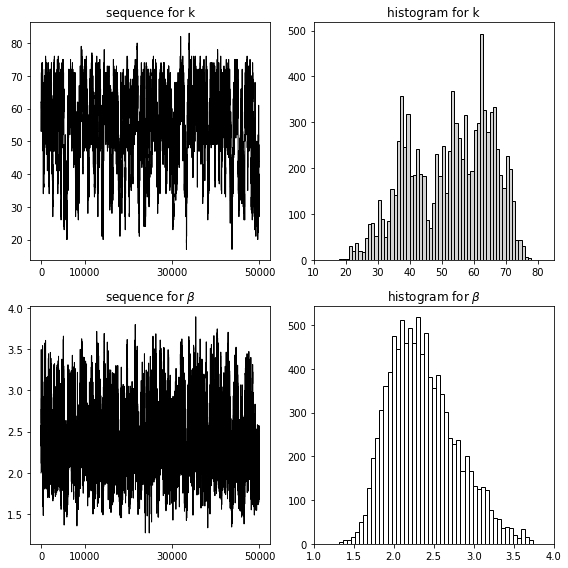

In [22]:
## figure 4

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=((8, 8)))
ax1[0].plot(beta_k[:,1], linewidth=1, color="black")
ax1[0].set_title('sequence for k')
ax1[0].set_xticks([0, 10_000, 30_000, 50_000])
ax1[1].hist(beta_k[-10_000:,1], bins=np.arange(1, K, 1), edgecolor="black", color="lightgray")
ax1[1].set_title('histogram for k')
ax1[1].set_xlim(10, 85)

ax2[0].plot(beta_k[:,0], linewidth=1, color="black")
ax2[0].set_title(r'sequence for $\beta$')
ax2[0].set_xticks([0, 10_000, 30_000, 50_000])
ax2[1].hist(beta_k[-10_000:,0], bins=np.linspace(0, 4, 80, endpoint=True), edgecolor="black", color="white")
ax2[1].set_title(r'histogram for $\beta$')
ax2[1].set_xlim(1, 4)

plt.tight_layout()
plt.show()

In [24]:
import pickle

with open('data/approach1_beta_k.pickle', 'wb') as handle:
    pickle.dump(beta_k, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# import pickle

# with open('data/approach1_beta_k.pickle', 'rb') as handle:
#     beta_k = pickle.load(handle)

In [26]:
def predict(x, X, y, beta_k_list):
    scores = np.zeros(2)
    for beta, k in beta_k_list:
        scores += pred_dist(np.arange(2), x, X, y, beta, k.astype(int))
    return np.argmax(scores)

In [27]:
test_score = 0
for x, y in tqdm(zip(X_te, y_te)):
    test_score += predict(x, X_tr, y_tr, beta_k[-1000:]) == y
test_score /= X_te.shape[0]
print('Test score with pseudolikelihood: ', test_score)

1000it [05:36,  2.97it/s]

Test score with pseudolikelihood:  0.916


## $2^{nd}$ approach: path sampling

In [ ]:
beta_max = 4
betas = np.linspace(0, beta_max, 50) # precise number is not specified in the paper but not a good look for 20
left, right = np.empty(len(betas)), np.empty(len(betas))
for i, beta in enumerate(tqdm(betas)):
    left[i] = expectation(beta, 1, y_tr, X_tr, n_iter=10**4, burn_in=500)
    right[i] = expectation(beta, 125, y_tr, X_tr, n_iter=10**4, burn_in=500)

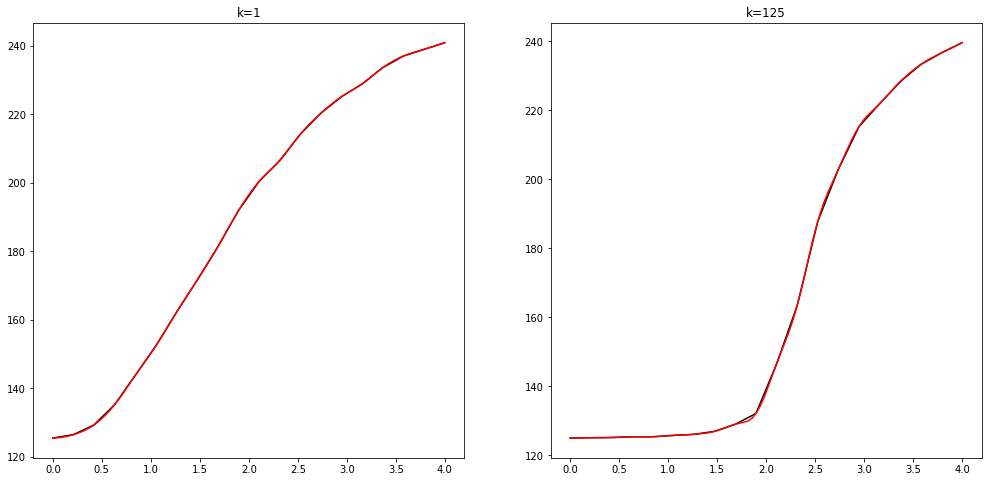

In [ ]:
## figure 5
f, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(17, 8))
ax0.plot(betas, left, color="black")
ax0.set_title("k=1")

ax1.plot(betas, right, color="black")
ax1.set_title("k=125")
plt.show()

In [32]:
from scipy.interpolate import make_interp_spline
left_interpolation = make_interp_spline(betas, left, k=2)
right_interpolation = make_interp_spline(betas, right, k=2)

Unfortunately, although we have implemented what we would have had to do next for this method, we were not able to run it is extremely time consuming to compute the meshgrid for $\log Z$.

In [ ]:
range_beta = np.linspace(0, beta_max, 50)
range_k = [1] + list(range(10, 111, 10)) + [125]

betas, ks = np.meshgrid(range_beta, range_k)
log_Z_ = log_Z(betas, ks)

In [ ]:
log_Z_.shape

In [ ]:
## figure 6
plt.figure()
plt.grid()
c = plt.pcolormesh(range_k, range_beta, log_Z_, cmap="YlOrRd")
plt.colorbar(c)

# level lines
for value in np.arange(200, 1001, 100):
    ks_, betas_ = np.where(log_Z_ == value)
    plt.plot(ks_, betas_, color="black", linewidth=1)

plt.xticks(np.arange(20, 121, 20))
plt.yticks(np.arange(0, 5))
plt.show()

In [ ]:
beta_max = 4
K = min(np.count_nonzero(y_tr == 0), np.count_nonzero(y_tr == 1))

beta_k = metropolis_hastings(
        n_iter=50_000, n_burnin=0,
        joint_dist_y=true_likelihood, 
        beta_max=beta_max, K=K, 
        X=X_tr, y=y_tr, 
        r=3, tau=np.sqrt(0.05), 
        theta0=0, k0=K//2,
        log=False,
    )

## New prior on $\theta$

We redefine the metropolis_hastings algorithm, taking for example a parabolic (particular symmetric Beta distribution) prior on $\beta$.  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rdist.html

In [22]:
from scipy.stats import rdist

In [23]:
@jit(fastmath=True)
def metropolis_hastings(n_iter, joint_dist_y, beta_max, K, X, y, r, tau, theta0=0, k0=1, n_burnin=0, log:bool=False):
    assert n_iter > n_burnin, "`n_iter` must be larger than `n_burnin`"
    
    theta, k = theta0, k0
    beta = logistic(theta)*beta_max

    chain = np.zeros((n_iter, 2))
    chain[0] = beta, k

    posterior = joint_dist_y(y, X, beta, k, log=log)

    for n in tqdm(range(n_iter)):
        ## Random Walk beta
        theta_ = np.random.normal(theta, tau)
        beta_ = logistic(theta_)*beta_max

        ## Random Walk k
        new_k_support = list(range(max(1, k - r), k)) + list(range(k + 1, min(K, k + r) + 1))
        k_ = np.random.choice(new_k_support)
        Qr_forward = 1/len(new_k_support)
        Qr_backward = 1/(min(K, k_ + r) - max(1, k_ - r))

        ## Acceptance ratio
        new_posterior = joint_dist_y(y, X, beta_, k_, log=log)
        
        if log:
            rho = np.exp(new_posterior - posterior)
        else:
            rho = new_posterior/posterior
        rho *= Qr_backward/Qr_forward * np.exp(theta_)*(1 + np.exp(theta))**2/np.exp(theta)/(1 + np.exp(theta_))**2\
            * rdist.pdf(beta_, c=4)/rdist.pdf(beta_, c=4) # This time, the priors on beta do not cancel out

        ## Acceptance
        if np.random.rand() < rho:
            theta, beta, k = theta_, beta_, k_
            posterior = new_posterior
        
        ## update the chain
        chain[n] = beta, k
    return chain[n_burnin:]

In [ ]:
beta_max = 4
K = min(np.count_nonzero(y_tr == 0), np.count_nonzero(y_tr == 1))

beta_k = metropolis_hastings(
        n_iter=2000, n_burnin=1000,
        joint_dist_y=pseudo_likelihood, 
        beta_max=beta_max, K=K, 
        X=X_tr, y=y_tr, 
        r=3, tau=np.sqrt(0.05), 
        theta0=0, k0=K//2,
        log=False,
    )

In [27]:
test_score = 0
for x, y in tqdm(zip(X_te, y_te)):
    test_score += predict(x, X_tr, y_tr, beta_k[-1000:]) == y
test_score /= X_te.shape[0]
print('Test score with pseudolikelihood: ', test_score)

0it [00:00, ?it/s]C:\Users\maxim\AppData\Local\Temp\ipykernel_88464\3618351254.py:9: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(x, int): # x is the xth entry of X
C:\Users\maxim\AppData\Local\Temp\ipykernel_88464\3618351254.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "k_neighbours" failed type inference due to: No implementation of function Function(<function norm at 0x000001E5B7110E50>) found for signature:
 
 >>> norm(array(float64, 2d, C), axis=Literal[int](1))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'norm_impl': File: numba\np\linalg.py: Line 2351.
        With argument(s): '(array(float64, 2d, C), axis=int64)':
       Rejected as the implementation raised a specific error:
         TypingError: got an unexpected keyword argument 'axis'
  raised from c:\Users\maxim\AppData\Local\Progra

Test score with pseudolikelihood:  0.917


# 